In [66]:
from tqdm import tqdm
from filters import sobel_filter

In [24]:
 
from matplotlib import pyplot
from matplotlib.patches import Circle, ConnectionPatch

from timeit import default_timer as timer
import numpy as np

import imageIO.readwrite as IORW
import imageProcessing.pixelops as IPPixelOps
import imageProcessing.utilities as IPUtils
import imageProcessing.smoothing as IPSmooth

from harris_corner_detector import get_harris_corners
from DoG import DoG
from feature_functions import get_search_area

from feature_matching import match_features


# this is a helper function that puts together an RGB image for display in matplotlib, given
# three color channels for r, g, and b, respectively
def prepareRGBImageFromIndividualArrays(r_pixel_array,g_pixel_array,b_pixel_array,image_width,image_height):
    rgbImage = []
    for y in range(image_height):
        row = []
        for x in range(image_width):
            triple = []
            triple.append(r_pixel_array[y][x])
            triple.append(g_pixel_array[y][x])
            triple.append(b_pixel_array[y][x])
            row.append(triple)
        rgbImage.append(row)
    return rgbImage


# takes two images (of the same pixel size!) as input and returns a combined image of double the image width
def prepareMatchingImage(left_pixel_array, right_pixel_array, image_width, image_height):

    matchingImage = IPUtils.createInitializedGreyscalePixelArray(image_width * 2, image_height)
    for y in range(image_height):
        for x in range(image_width):
            matchingImage[y][x] = left_pixel_array[y][x]
            matchingImage[y][image_width + x] = right_pixel_array[y][x]

    return matchingImage


def show_DoG(px_array_left, px_array_right, sigma=1, k=1.6,n=6, nms_window=13, nms_height=3, max_features=1000, single_image=False):
    start = timer()
    left_blobs = DoG(px_array_left, sigma=sigma, k=k,n=n, nms_window=nms_window, nms_height=nms_height, max_features=max_features)
    right_blobs = DoG(px_array_right, sigma=sigma, k=k,n=n, nms_window=nms_window, nms_height=nms_height, max_features=max_features)
    end = timer()
    print("elapsed time of blob detection for both images: ", end - start)

    if not single_image:
        fig1, axs1 = pyplot.subplots(1, 2)
        axs1[0].set_title('DoG response left overlaid on orig image')
        axs1[1].set_title('DoG response right overlaid on orig image')
        axs1[0].imshow(px_array_left, cmap='gray')
        axs1[1].imshow(px_array_right, cmap='gray')

        for corner_point in left_blobs:
            circle = Circle(corner_point[:2], corner_point[2] * 2**0.5, color='red', linewidth=1, fill=False)
            axs1[0].add_patch(circle)

        for corner_point in right_blobs:
            circle = Circle(corner_point[:2], corner_point[2] * 2**0.5, color='red', linewidth=1, fill=False)
            axs1[1].add_patch(circle)

    else:
        fig1, axs1 = pyplot.subplots()
        fig1.suptitle(f'Sigma={sigma}, k={k}, n={n}, nms_window={nms_window}x{nms_window}x{nms_height}, max_blobs={max_features}')

        axs1.set_title('DoG response overlaid on orig image')
        axs1.imshow(px_array_left, cmap='gray')
        for corner_point in left_blobs:
            circle = Circle(corner_point[:2], corner_point[2] * 2**0.5, color='red', linewidth=1, fill=False)
            axs1.add_patch(circle)

    pyplot.show()



In [46]:
filename = "./images/panoramaStitching/tongariro_right_01.png"
(image_width, image_height, px_array_original)  = IORW.readRGBImageAndConvertToGreyscalePixelArray(filename)
px_array = IPSmooth.computeGaussianAveraging3x3(px_array_original, image_width, image_height)
px_array = IPPixelOps.scaleTo0And255AndQuantize(px_array, image_width, image_height)

image_width = 750
left_array = np.float32(px_array)[:, 0:image_width]
right_array = np.float32(px_array)[:, 250:(250+image_width)]


read image width=1000, height=750
before scaling, min value = 0, max value = 252.21425735919996


In [47]:

start = timer()
left_im_corners = get_harris_corners(left_array, blur_kernal_size=5, adaptive_threshold=False, num_of_corners=100)
right_im_corners = get_harris_corners(right_array, blur_kernal_size=5, adaptive_threshold=False, num_of_corners=100)
end = timer()
print("elapsed time of corner detection for both images: ", end - start)

elapsed time of corner detection for both images:  7.082240124999998


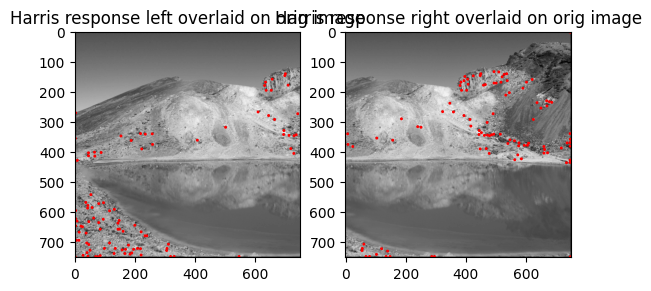

In [48]:
fig1, axs1 = pyplot.subplots(1, 2)
axs1[0].set_title('Harris response left overlaid on orig image')
axs1[1].set_title('Harris response right overlaid on orig image')
axs1[0].imshow(left_array, cmap='gray')
axs1[1].imshow(right_array, cmap='gray')

#Plot corners points on image
for i, corner_point in enumerate(left_im_corners):
    circle = Circle(corner_point, 2.5, color='r')
    #axs1[0].text(corner_point[0], corner_point[1], i)
    axs1[0].add_patch(circle)

for i, corner_point in enumerate(right_im_corners):
    circle = Circle(corner_point, 2.5, color='r')
    #axs1[1].text(corner_point[0], corner_point[1], i)
    axs1[1].add_patch(circle)

pyplot.show()

In [49]:
def compute_hog_cell(n_orientations, magnitudes, orientations):
    bin_width = int(180 / n_orientations)
    hist = np.zeros(n_orientations)
    rav_orientations = orientations.ravel()
    rav_magnitudes = magnitudes.ravel()
    assert len(rav_orientations) == len(rav_magnitudes); "Somehow the patches arent the same size"
    for i in range(len(rav_orientations)):
        orientation = rav_orientations[i]
        magnitude = rav_magnitudes[i]
        lower_bin_idx = min(int(orientation / bin_width), n_orientations-1)
        upper_bin_idx = (lower_bin_idx + 1) % n_orientations
        proportion_upper = (orientation % bin_width)/bin_width
        hist[upper_bin_idx] = magnitude * proportion_upper
        hist[lower_bin_idx] = magnitude * (1-proportion_upper)

    return hist

def get_hog_descriptor(magnitudes, orientations, col, row, patch_size=36, cell_size=4):
    mag_patch = get_search_area(magnitudes, col, row, patch_size)
    ori_patch = get_search_area(orientations, col, row, patch_size)
    cells = []
    for y in range(0, patch_size, cell_size):
        for x in range(0, patch_size, cell_size):
            mag_cell = mag_patch[y:y + cell_size, x:x + cell_size]  # Extract cell from patch
            ori_cell = ori_patch[y:y + cell_size, x:x + cell_size]
            hog_cell = compute_hog_cell(9, mag_cell, ori_cell)
            hog_cell[:] /= np.sum(np.abs(hog_cell+1E-10))
            cells.append(hog_cell)
    hog_descriptor = np.stack(cells)
    return np.sum(hog_descriptor, axis=0)

def histograms(px_array, corners, window=9, n_orientations = 9):
    image = np.float32(px_array)/255
    gx,gy = sobel_filter(image)
    magnitudes = np.hypot(gx, gy)
    orientations = np.rad2deg(np.arctan2(gy, gx)) % 180

    histograms = np.zeros((image.shape[0],image.shape[1], n_orientations))
    for col,row in tqdm(corners):
        histograms[row,col,:] = get_hog_descriptor(magnitudes, orientations, col, row, patch_size=36, cell_size=4)

    return histograms

In [50]:
left_histograms = histograms(left_array, left_im_corners)
right_histograms = histograms(right_array, right_im_corners)

100%|██████████| 100/100 [00:00<00:00, 220.52it/s]


In [61]:
def distance(hist1, hist2):
    dist = np.linalg.norm(hist1-hist2)
    return dist

In [64]:
corner_pairs = []
dup_right_corners = list(right_im_corners)
for col, row in left_im_corners:
    target_hist = left_histograms[row,col,:]
    closest_match = None
    closest_dist = 1E10
    second_closest_dist = 1E10
    closest_i = None
    for i, (col_r, row_r) in enumerate(dup_right_corners):
        right_hist = right_histograms[row_r,col_r,:]
        dist = distance(target_hist, right_hist)
        if dist < closest_dist:
            second_closest_dist = closest_dist
            closest_dist = dist
            closest_match = (col_r,row_r)
            closest_i = i
        elif dist < second_closest_dist:
            second_closest_dist = dist
    if closest_dist / second_closest_dist < 0.8:
        corner_pairs.append([(col, row), closest_match])
        dup_right_corners.pop(closest_i)
        


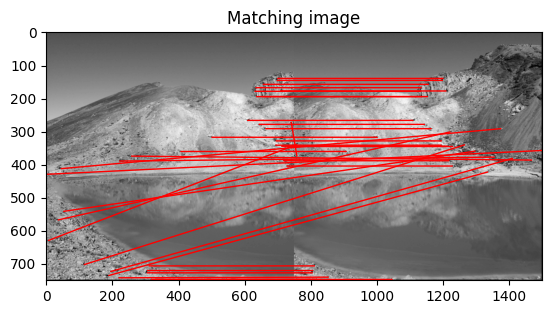

In [65]:
matchingImage = prepareMatchingImage(left_array, right_array, image_width, image_height)

pyplot.imshow(matchingImage, cmap='gray')
ax = pyplot.gca()
ax.set_title("Matching image")

for p1, p2 in corner_pairs:
    connection = ConnectionPatch(p1, (p2[0] + image_width, p2[1]), "data", edgecolor='r', linewidth=1)
    ax.add_artist(connection)